In [288]:
import numpy as np
import matplotlib.pyplot as plt

# import time
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

from nf.TNF import *
from nf.models import NormalizingFlowModel

from tensorboardX import SummaryWriter

from shapely.geometry import Point, Polygon
from matplotlib.animation import FuncAnimation

In [289]:
# Define fixed colormap
myCmap = plt.cm.viridis  
cmap_norm = plt.Normalize(vmin=-1, vmax=1)  # Define the range of the colormap

def plot_data(samples, isColor=False, **kwargs):

    if isColor:
        x = samples[:, 0]
        y = samples[:, 1]
        colors = samples[:, 2]    
        plt.scatter(x, y, c=colors, cmap=myCmap, alpha=0.5, s=3.5, norm=cmap_norm)
        plt.colorbar(label='alpha')
        plt.xlabel('x')
        plt.ylabel('y')

    else:
        plt.scatter(samples[:, 0], samples[:, 1], s=1, marker="o", **kwargs)    
        plt.xlabel("x")
        plt.ylabel("y")


In [290]:
argparser = ArgumentParser()
argparser.add_argument("--n", default=512, type=int)
argparser.add_argument("--flows", default=1, type=int)
argparser.add_argument("--flow", default="RealNVP", type=str)
argparser.add_argument("--iterations", default=25000, type=int)
argparser.add_argument("--use-mixture", action="store_true")
argparser.add_argument("--convolve", action="store_true")
argparser.add_argument("--actnorm", action="store_true")
args = argparser.parse_args(args=[]) 
# logging.basicConfig(level=logging.DEBUG)
# logger = logging.getLogger(__name__)

flow = eval(args.flow)
flows = [flow(dim=3) for _ in range(args.flows)]
prior = MultivariateNormal(torch.zeros(3), torch.eye(3))
model = NormalizingFlowModel(prior, flows)
optimizer = optim.Adam(model.parameters(), lr=0.001)
T = 1
dt = 0.05
# time, position_x, position_y = GeneratingData(T, dt, 500)

In [291]:
# read the hull points from file
with open('hull_points.txt', 'r') as f:
    lines = f.readlines()
    cell_coords = np.zeros((len(lines), 2))
    for i in range(len(lines)):
        line = lines[i].split('\t')
        cell_coords[i,0] = float(line[0])
        cell_coords[i,1] = float(line[1])

# print(cell_coords)

In [292]:
cutoff = 20
numchosen = 89
newx = np.zeros((cutoff*numchosen,4))
# read from file the first, second, and fourth columns
with open('new_traj_frame_wise.txt', 'r') as f:
    for i in range(cutoff*numchosen):
        line = f.readline()
        line = line.split('\t')
        newx[i,0] = float(line[0])
        newx[i,1] = float(line[1])
        newx[i,2] = float(line[2])
        newx[i,3] = float(line[3])

newx = torch.Tensor(newx)
print('shape of newx', newx.shape)

x = newx

numNegSamples = 27
negSamples = np.zeros((cutoff*numNegSamples,4))
times = np.arange(0, 1.0, 0.05)

with open('neg_samples.txt', 'r') as f:
    for i in range(numNegSamples):
        line = f.readline()
        line = line.split()
        negSamples[i*cutoff:(i+1)*cutoff,0] = float(line[0])
        negSamples[i*cutoff:(i+1)*cutoff,1] = float(line[1])
        negSamples[i*cutoff:(i+1)*cutoff,2] = np.random.uniform(0, 1, cutoff)
        negSamples[i*cutoff:(i+1)*cutoff,3] = times

print('shape of negSamples', negSamples.shape)
# print(negSamples)
negSamples = torch.Tensor(negSamples)

shape of newx torch.Size([1780, 4])
shape of negSamples (540, 4)


In [293]:
L2term = np.zeros((negSamples.shape[0],1))
# print('shape of L2term', L2term.shape)

cell_polygon = Polygon(cell_coords)
for i in range(negSamples.shape[0]):
    point = Point(negSamples[i,0].item(), negSamples[i,1].item())
    # L2term[i] = cell_polygon.contains(point)
    L2term[i] = (cell_polygon.distance(point))**2

# convert to tensor
L2term = torch.Tensor(L2term)
# print(L2term)


In [294]:
# writer = SummaryWriter('2Duni')
Loss = np.zeros([args.iterations, 1])
for i in range(args.iterations):
    optimizer.zero_grad()
    z, prior_logprob, log_det, px = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.mean(logprob)
    # loss += torch.mean(L2term**2)
    loss.backward()
    optimizer.step()
    Loss[i] = loss.detach().numpy()
    # writer.add_scalar('Loss', loss.item(), i)
    if i % 100 == 0:
        print("Loss at iteration", i, ":", loss.item())
        # print("L2 term at iteration", i, ":", torch.mean(L2term**2).item())
        print("Prior logprob at iteration", i, ":", torch.mean(prior_logprob).item())
        print("Log det at iteration", i, ":", torch.mean(log_det).item())
        print()
    # # negative samples
    # optimizer.zero_grad()
    # z, prior_logprob, log_det, px = model(negSamples)
    # logprob = prior_logprob + log_det
    # xval = torch.pow(10,logprob)
    # act_logprob = torch.log10(1-xval)
    # loss = -torch.mean(act_logprob)
    # # loss += torch.mean(L2term**2)
    # loss.backward()
    # optimizer.step()
# writer.close()
np.save('2Dloss_Ex1.npy',Loss)

Loss at iteration 0 : 43830.9375
Prior logprob at iteration 0 : -43831.16796875
Log det at iteration 0 : 0.22923550009727478



Loss at iteration 100 : 67.42515563964844
Prior logprob at iteration 100 : -61.712650299072266
Log det at iteration 100 : -5.712502956390381

Loss at iteration 200 : 28.75233268737793
Prior logprob at iteration 200 : -22.766672134399414
Log det at iteration 200 : -5.985659122467041

Loss at iteration 300 : 16.912342071533203
Prior logprob at iteration 300 : -10.463290214538574
Log det at iteration 300 : -6.449051856994629

Loss at iteration 400 : 13.586915969848633
Prior logprob at iteration 400 : -6.6975483894348145
Log det at iteration 400 : -6.889367580413818

Loss at iteration 500 : 12.588544845581055
Prior logprob at iteration 500 : -5.4731125831604
Log det at iteration 500 : -7.115431785583496

Loss at iteration 600 : 12.181607246398926
Prior logprob at iteration 600 : -4.9117841720581055
Log det at iteration 600 : -7.2698235511779785

Loss at iteration 700 : 11.959875106811523
Prior logprob at iteration 700 : -4.6155524253845215
Log det at iteration 700 : -7.3443217277526855

Lo

In [295]:
# load all the data from file
with open('20170202c059_RPE1_CAG_H2B_Halotag_TMR80pM_nonlam_non_starve_ctrl_info.txt', 'r') as f:
    lines = f.readlines()
    coords = np.zeros((len(lines), 2))
    for i in range(len(lines)):
        line = lines[i].split('\t')
        coords[i,0] = float(line[2])
        coords[i,1] = float(line[3])

# # plot the data
# plt.figure()
# # plot all points
# plt.plot(coords[:,0], coords[:,1], 'o', color='black', markersize=1, alpha=0.5)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Data')
# plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ff2ba182ef0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ff2b9bdbaf0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ff2b9f19a20>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ff2b9fedba0>


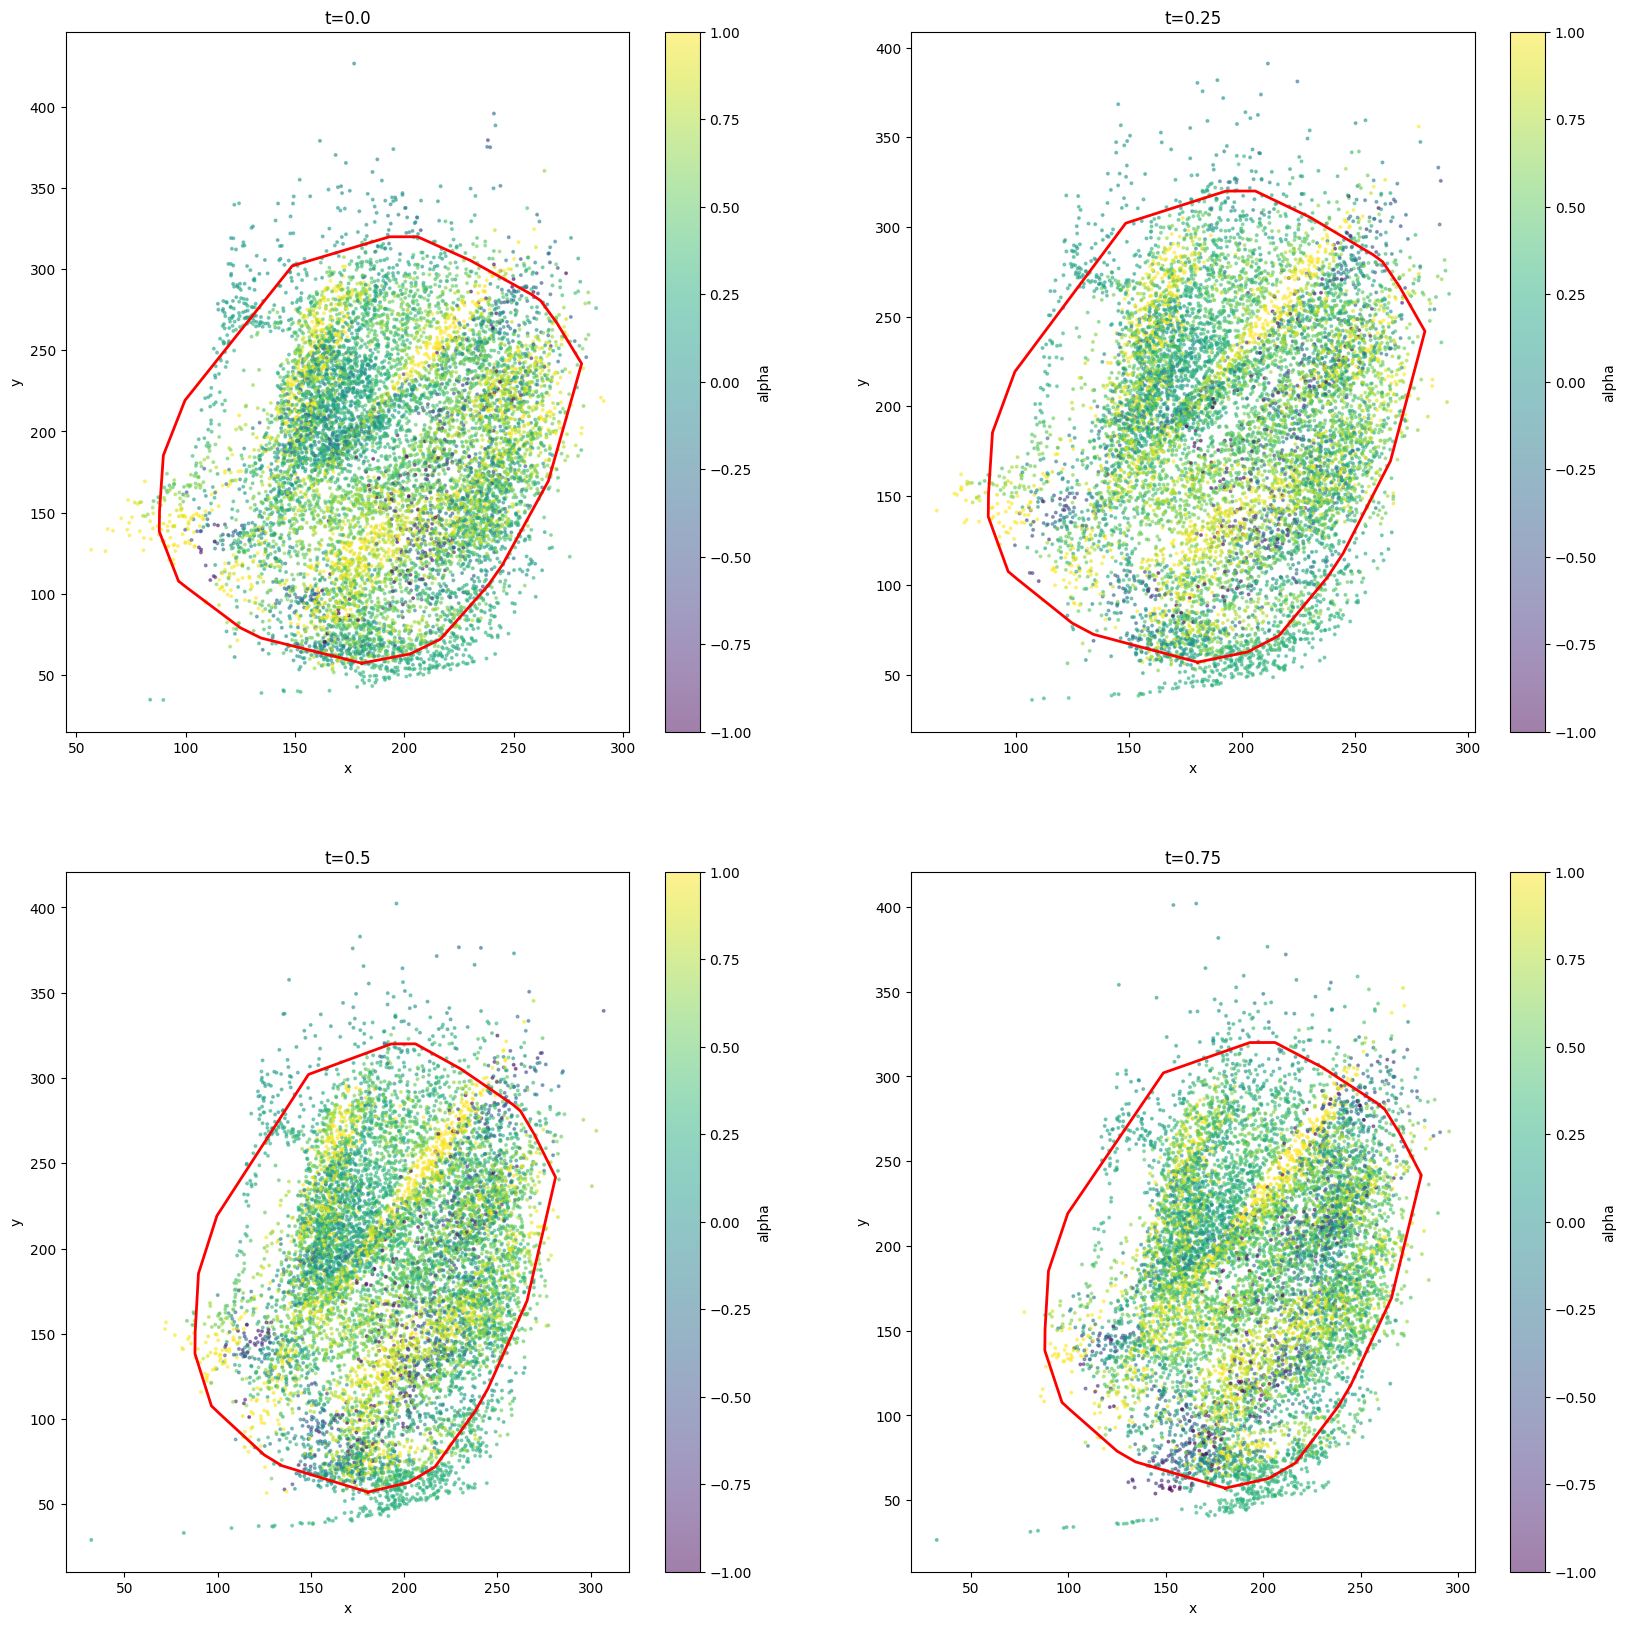

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ff2b9f5d180>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


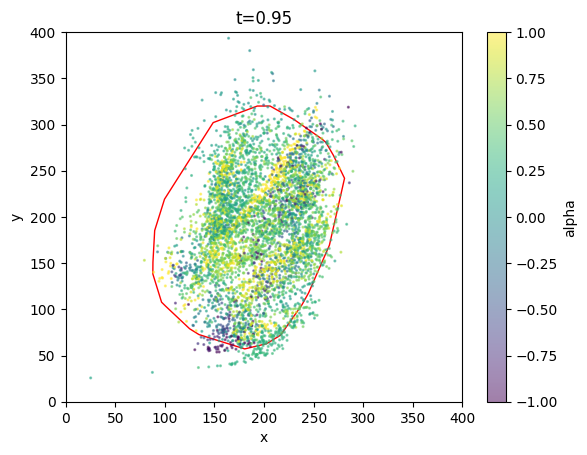

In [296]:
position_x = np.reshape(x[:,0].detach().numpy(), (cutoff, numchosen), order='C')
position_y = np.reshape(x[:,1].detach().numpy(), (cutoff, numchosen), order='C')

# close the polygon
cell_coords_closed = np.append(cell_coords, [cell_coords[0]], axis=0)

# Resampling
plt.figure(figsize=(20,20))

plt.subplot(2, 2, 1)
samples = model.sample(10000, t=0).data
plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
plot_data(samples, isColor=True, color="black", alpha=0.5)
# plt.xlim((0,400))
# plt.ylim((0,400))
plt.title("t=0.0")

plt.subplot(2, 2, 2)
samples = model.sample(10000, t=0.25).data
plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
plot_data(samples, isColor=True, color="black", alpha=0.5)
# plt.grid()
# plt.xlim((0,300))
# plt.ylim((0,350))
plt.title("t=0.25")

plt.subplot(2, 2, 3)
samples = model.sample(10000, t=0.5).data
plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
plot_data(samples, isColor=True, color="black", alpha=0.5)
# plt.xlim((0,400))
# plt.ylim((0,400))
plt.title("t=0.5")

plt.subplot(2, 2, 4)
samples = model.sample(10000, t=0.75).data
plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
plot_data(samples, isColor=True, color="black", alpha=0.5)
# plt.xlim((0,400))
# plt.ylim((0,400))
plt.title("t=0.75")
plt.show()

# show a gif of the distribution over time using FuncAnimation
fig, ax = plt.subplots()
ax.set_xlim((0, 400))
ax.set_ylim((0, 400))
polygon = plt.Polygon(cell_coords_closed, closed=True, fill=None, edgecolor='r')
ax.add_patch(polygon)
sc = plt.scatter([], [], s=1.5, c=[], cmap=myCmap, alpha=0.5, norm=cmap_norm)
plt.colorbar(sc, label='alpha')
plt.xlabel('x')
plt.ylabel('y')

def update(frame):
    samples = model.sample(5000, t=frame).data
    sc.set_offsets(samples)
    sc.set_array(samples[:,2])
    # set title
    ax.set_title(f't={frame:.2f}')
    return sc,
ani = FuncAnimation(fig, update, frames=np.linspace(0, 1, 21)[:-1], blit=True)
ani.save('2Duni.gif', fps=3)
# plt.show()



In [297]:
# # writer = SummaryWriter('2Duni')
# Loss = np.zeros([args.iterations, 1])
# for i in range(args.iterations):
#     optimizer.zero_grad()
#     z, prior_logprob, log_det, px = model(negSamples)
#     logprob = prior_logprob + log_det
#     xval = torch.pow(10,logprob)
#     act_logprob = torch.log10(1-xval)
#     loss = -torch.mean(act_logprob)
#     # loss += torch.mean(L2term**2)
#     loss.backward()
#     optimizer.step()
#     Loss[i] = loss.detach().numpy()
#     writer.add_scalar('Loss', loss.item(), i)
#     if i % 100 == 0:
#         print("Loss at iteration", i, ":", loss.item())
#         # print("L2 term at iteration", i, ":", torch.mean(L2term**2).item())
#         print("Prior logprob at iteration", i, ":", torch.mean(prior_logprob).item())
#         print("Log det at iteration", i, ":", torch.mean(log_det).item())
#         print()

# # writer.close()
# # np.save('2Dloss_Ex1.npy',Loss)

In [298]:
# position_x = np.reshape(x[:,0].detach().numpy(), (cutoff, numchosen), order='C')
# position_y = np.reshape(x[:,1].detach().numpy(), (cutoff, numchosen), order='C')

# # close the polygon
# cell_coords_closed = np.append(cell_coords, [cell_coords[0]], axis=0)

# # Resampling
# plt.figure(figsize=(20,20))

# plt.subplot(2, 2, 1)
# samples = model.sample(10000, t=0).data
# plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
# plot_data(samples, isColor=True, color="black", alpha=0.5)
# # plt.xlim((0,400))
# # plt.ylim((0,400))
# plt.title("t=0.0")

# plt.subplot(2, 2, 2)
# samples = model.sample(10000, t=0.25).data
# plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
# plot_data(samples, isColor=True, color="black", alpha=0.5)
# # plt.grid()
# # plt.xlim((0,300))
# # plt.ylim((0,350))
# plt.title("t=0.25")

# plt.subplot(2, 2, 3)
# samples = model.sample(10000, t=0.5).data
# plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
# plot_data(samples, isColor=True, color="black", alpha=0.5)
# # plt.xlim((0,400))
# # plt.ylim((0,400))
# plt.title("t=0.5")

# plt.subplot(2, 2, 4)
# samples = model.sample(10000, t=0.75).data
# plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
# plot_data(samples, isColor=True, color="black", alpha=0.5)
# # plt.xlim((0,400))
# # plt.ylim((0,400))
# plt.title("t=0.75")
# plt.show()

In [299]:
# save the model
torch.save(model, '2Duni.pth')

# load the model
# model = torch.load('2Duni.pth')